In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
from datetime import datetime
import lightgbm as lgb
from dotenv import load_dotenv
load_dotenv() 
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from scipy.fft import fft, ifft

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.config import TRANSFORMED_DATA_DIR
from src.data_utils import split_time_series_data
from src.experiment_utils import set_mlflow_tracking, log_model_to_mlflow


In [2]:
def split_time_series_data_percentage(
    df: pd.DataFrame,
    target_column: str,
) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a time series DataFrame into training, validation, and testing sets (70%, 20%, 10%).

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        target_column (str): The name of the target column to separate from the features.

    Returns:
        Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
            - X_train (pd.DataFrame): Training features (70% of data).
            - y_train (pd.Series): Training target values.
            - X_val (pd.DataFrame): Validation features (20% of data).
            - y_val (pd.Series): Validation target values.
            - X_test (pd.DataFrame): Testing features (10% of data).
            - y_test (pd.Series): Testing target values.
    """
    # Sort the DataFrame by date
    df_sorted = df.sort_values("pickup_hour")

    # Calculate the split indices
    train_end = int(len(df) * 0.5)
    val_end = int(len(df) * 0.8)

    # Split the data into training, validation, and testing sets
    train_data = df_sorted[:train_end].reset_index(drop=True)
    val_data = df_sorted[train_end:val_end].reset_index(drop=True)
    test_data = df_sorted[val_end:].reset_index(drop=True)

    # Separate features (X) and target (y) for all three sets
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_val = val_data.drop(columns=[target_column])
    y_val = val_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]

    return X_train, y_train, X_val, y_val, X_test, y_test

df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")
df.head(5)
df.shape
X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data_percentage(df, target_column="target")

In [3]:
def apply_fft(data):
    # Apply FFT
    fft_result = fft(data)
    
    # You can perform frequency domain operations here if needed
    
    # Inverse FFT to get back to time domain
    ifft_result = ifft(fft_result)
    
    return fft_result, ifft_result

y_train_fft = apply_fft(y_train)
y_val_fft = apply_fft(y_val)
y_test_fft = apply_fft(y_test)

In [4]:
y_train_fft

(array([496891.            -0.j        , -12047.05053735+11266.48625237j,
        -13417.93589913 +2578.28468926j, ...,
         -8854.7913364  -3887.89783871j, -13417.93589913 -2578.28468926j,
        -12047.05053735-11266.48625237j]),
 array([-5.31455475e-15+0.00000000e+00j, -3.72007399e-14-1.59463319e-14j,
         2.00000000e+00+1.77744349e-14j, ...,
         3.00000000e+00+1.48190572e-14j,  4.00000000e+00-2.95991895e-15j,
        -9.30275741e-15+3.18866615e-14j]))

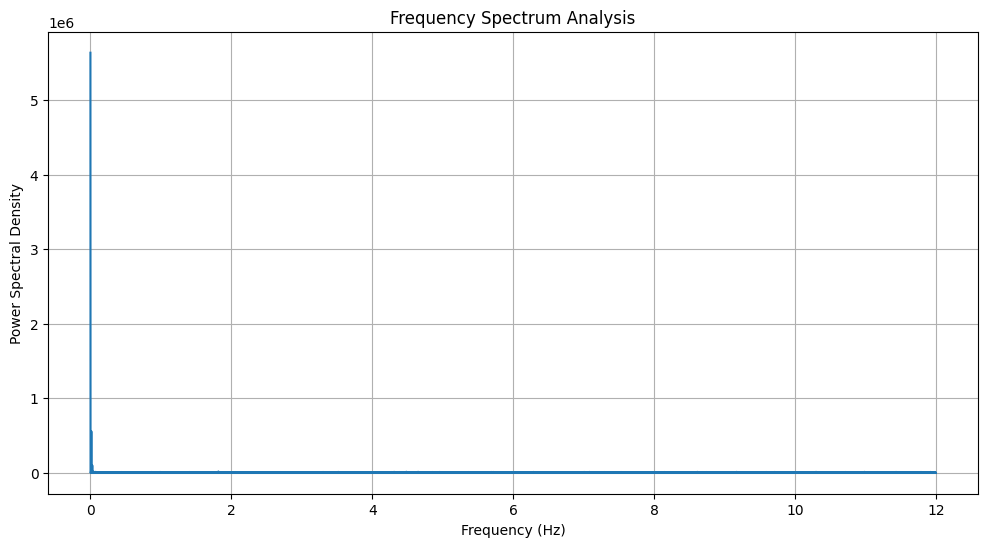

Dominant frequency: 0.00 Hz


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_fft(time_series, sample_rate):
    # time_series = time_series/len(time_series) # Added code here to scale (to test for scale errors) - May fix high initial results
    # Apply FFT
    fft_result = np.fft.fft(time_series)
    
    # Compute frequencies
    frequencies = np.fft.fftfreq(len(time_series), d=1/sample_rate)
    
    # Calculate power spectral density
    psd = np.abs(fft_result)**2 / len(time_series)
    
    # Plot the power spectral density
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies[:len(frequencies)//2], psd[:len(psd)//2])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title('Frequency Spectrum Analysis')
    plt.grid(True)
    plt.show()
    
    # Identify dominant frequencies
    dominant_freq_index = np.argmax(psd[:len(psd)//2])
    dominant_frequency = frequencies[dominant_freq_index]
    print(f"Dominant frequency: {dominant_frequency:.2f} Hz")

# Example usage
sample_rate = 24  # Assuming 24 samples per day
analyze_fft(y_train, sample_rate)
